<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install detecto

In [2]:
!pip install torch==1.4

     |████████████████████████████████| 753.4MB 20kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [3]:
!pip install torchvision==0.5.0

     |████████████████████████████████| 4.0MB 2.8MB/s 
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [25]:
from detecto import core, utils, visualize
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms

In [5]:
print(torch.cuda.is_available())

True


In [100]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Object detection - directory')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ls

 barchart.jpg		 images			 train_labels
 bar-horizontal_1.png	 sample-bar-chart.jpg	 val.csv
'Copy of 2138674.jpeg'	 smooth_line_chart.png	 val_labels
 food-pie-chart.jpg	 train.csv


In [ ]:
#utils.xml_to_csv('train_labels', 'train.csv')
#utils.xml_to_csv('val_labels', 'val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,bar98.jpg,1042,422,title,533,14,935,93
1,bar98.jpg,1042,422,legend,115,383,590,419
2,bar98.jpg,1042,422,axis label,8,24,29,99
3,bar81.jpg,481,289,title,221,18,328,46
4,bar91.jpg,448,224,legend,350,56,432,100
...,...,...,...,...,...,...,...,...
283,radar89.JPEG,602,391,title,61,15,577,33
284,radar89.JPEG,602,391,legend,28,46,158,132
285,scatter83.jpg,336,232,axis label,9,98,23,165
286,scatter83.jpg,336,232,axis label,145,206,203,225


In [86]:
#Gaussian noise function inspired from https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html
class Noise():
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, img):
        self.stddev = np.random.exponential(self.stddev)
        noise = torch.zeros_like(img).normal_(self.mean, self.stddev)
        return img.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},stddev={self.stddev})"
        return repr

In [87]:
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    Noise(mean=0.0, stddev=0.15), 
    utils.normalize_transform()
])

In [88]:
dataset = core.Dataset('train.csv', 'images/', transform=transform_img)

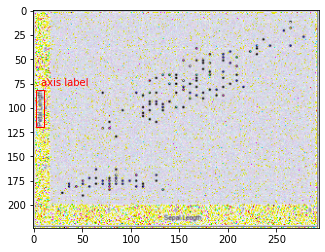

In [89]:
from detecto.visualize import show_labeled_image

image, targets = dataset[1000]
visualize.show_labeled_image(image, targets['boxes'], targets['labels'])

Epoch 1 of 5
Loss: 0.19540438143626992
Epoch 2 of 5
Loss: 0.1592806227854453
Epoch 3 of 5
Loss: 0.16032703150348324
Epoch 4 of 5
Loss: 0.152997743706995
Epoch 5 of 5
Loss: 0.15571472130250186


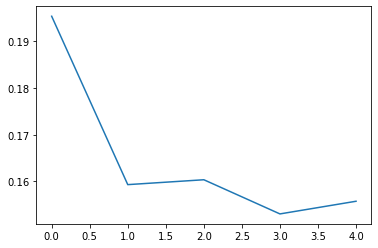

In [90]:
model = core.Model(['title', 'legend', 'axis label'])
val_dataset = core.Dataset('val.csv', 'images/')
loader = core.DataLoader(dataset=dataset, shuffle=True)
losses = model.fit(loader, val_dataset, epochs=5, verbose=True, learning_rate=0.001)
plt.plot(losses)
plt.show()

In [99]:
model.save('/content/drive/My Drive/Colab Notebooks/Obj det model noise.pth')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bar-horizontal.png to bar-horizontal.png


In [101]:
model2 = core.Model.load('/content/drive/My Drive/Colab Notebooks/Object detection model.pth', ['title', 'legend', 'axis label'])

In [102]:
image2 = utils.read_image('barchart.jpg')

In [103]:
images =[]
images.append(image2)

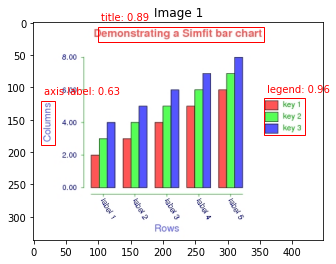

In [104]:
visualize.plot_prediction_grid(model2, images, score_filter=0.6)

In [110]:
predictions = model.predict_top(image2)
labels, boxes, scores = predictions

In [111]:
print(labels)

['title', 'legend', 'axis label']


In [112]:
print(boxes)

tensor([[ 96.0296,   5.7818, 351.3701,  27.7410],
        [355.3799, 116.9718, 420.3551, 175.1057],
        [ 12.2913, 121.5812,  32.2340, 187.3845]])


In [113]:
print(scores)

tensor([0.5950, 0.9827, 0.6459])


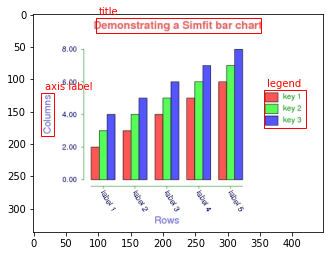

In [114]:
visualize.show_labeled_image(image2, boxes, labels)

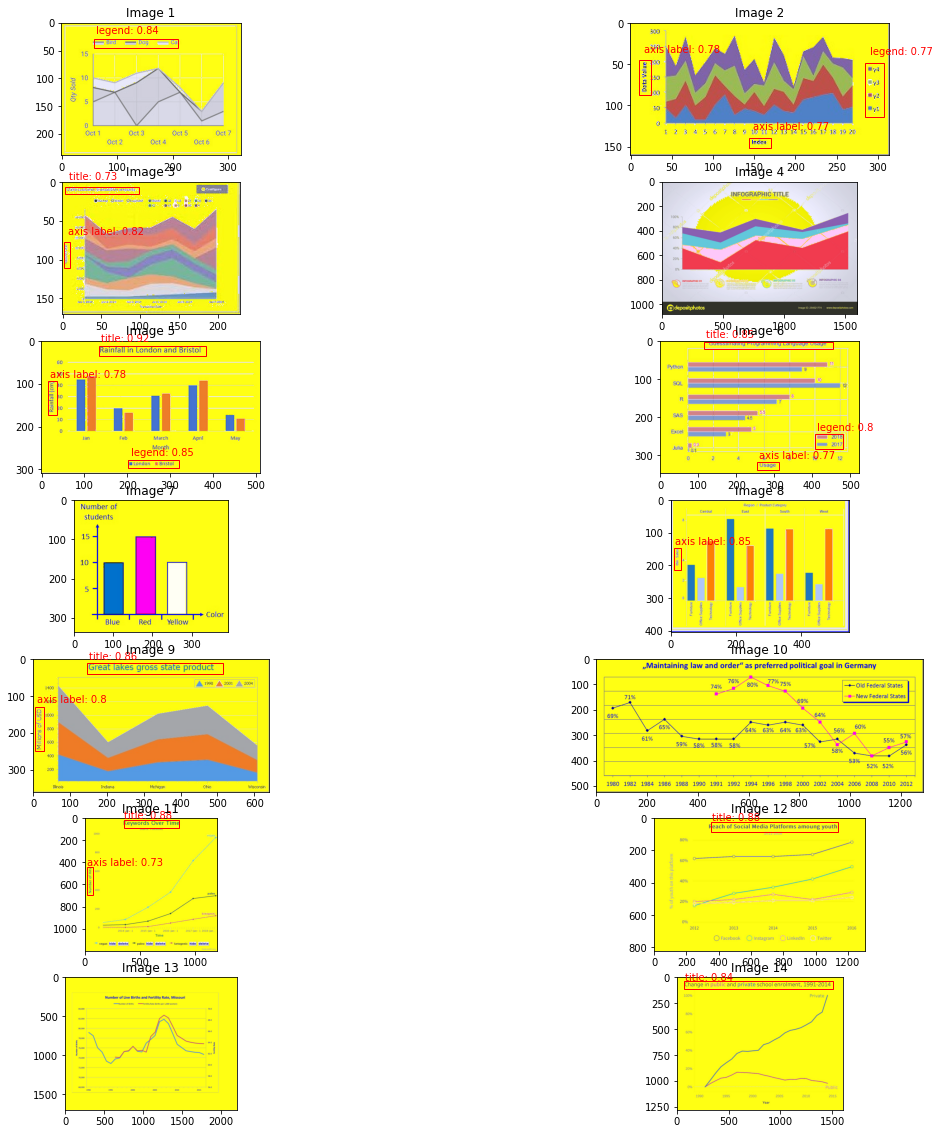

In [ ]:
img =[]
for i in range(0,140,10):
  img_temp, _ = val_dataset[i]
  img.append(img_temp)

visualize.plot_prediction_grid(model, img, dim=(7,2), figsize= (20,20), score_filter=0.7)

In [ ]:
pred = model.predict_top(img)

In [ ]:
l =[]
b=[]
s=[]
for i in range(0, 14, 1):
  for j in range(0,3,1):
    labels2, boxes2, scores2 = pred[j]
    l.append(labels2)
    b.append(boxes2)
    s.append(scores2)

In [ ]:
print(l)

[['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', 'legend'], ['axis label', 'title', 'legend'], ['axis label', 'legend'], ['axis label', '